In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

In [75]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [76]:
dataset = ImageFolder('../data/samples', transform=transform)

In [77]:
dataset.classes

['Active_Eyes', 'Fatigue_Eyes']

In [78]:
# split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(928, 233)

In [79]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

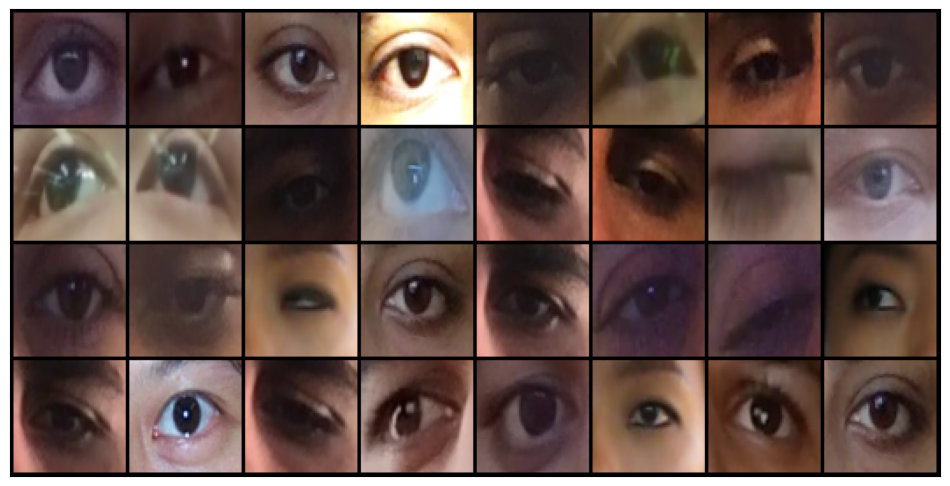

In [80]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


show_batch(train_loader)

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EyeClassifier(nn.Module):
    def __init__(self):
        super(EyeClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.classifier(x)
        return x

model = EyeClassifier()


In [88]:
from torchvision import models
class EyeClassifierResNet(nn.Module):
    def __init__(self):
        super(EyeClassifierResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(resnet.fc.in_features, 1) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = EyeClassifierResNet()

In [89]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train(model, criterion, optimizer, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch: {epoch+1}, Loss: {running_loss / i}")
    print("Finished Training")


train(model, criterion, optimizer, train_loader, test_loader, epochs=5)

Epoch: 1, Loss: 0.46152522042393684
Epoch: 2, Loss: 0.17710359647337878
Epoch: 3, Loss: 0.15724096540361643
Epoch: 4, Loss: 0.11346091097220778
Epoch: 5, Loss: 0.1041069214365312
Finished Training


In [90]:

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels.float().view(-1, 1)).sum().item()
    print(f"Accuracy: {100 * correct / total}")


evaluate(model, test_loader)

Accuracy: 92.70386266094421


In [96]:
# Save the model
torch.save(model.state_dict(), "../models/eye_classifier.pth")

In [97]:
# Load the model
model = EyeClassifierResNet()
model.load_state_dict(torch.load("../models/eye_classifier.pth"))
model

EyeClassifierResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin